In [438]:
from collections import defaultdict
import copy
import json
import pickle

import gym
from gym_minigrid.minigrid import Grid
from gym_minigrid.wrappers import FullyObsWrapper, ReseedWrapper, RGBImgObsWrapper
import matplotlib.pylab as plt
import networkx as nx
import numpy as np
from PIL import Image
import pytorch_ssim
import seaborn as sns
import sklearn
from skimage.transform import resize, rescale, downscale_local_mean
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn

from rlpyt.models.dqn.dsr.idf_model import IDFModel
from rlpyt.envs.gym import make as gym_make
from rlpyt.utils.seed import set_seed
from gym_minigrid.envs.multiroom import MultiRoomEnv

### 0. Environment setup

1. Downsample image 8x (200 x 200 --> 25 x 25)
2. 500 steps per episode
3. New agent position every episode

In [439]:
minigrid_config = {'size': [25, 25],
                   'steps': 500,
                   'reset_same': False,
                   'reset_episodes': 1}
mode = 'multiroom'
env_id=None
set_seed(333)

env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

using seed 333


In [440]:
# minigrid_config = {'size': [19, 19],
#                    'steps': 500,
#                    'reset_same': False,
#                    'reset_episodes': 1}
# mode = 'image'
# env_id='MiniGrid-FourRooms-v0'
# set_seed(333)

# env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

In [441]:
device = torch.device('cuda', 0)

### 1. Collect data

1. 10,000 total steps

In [442]:
steps = int(1e4)

In [443]:
eps_count = 0

In [444]:
obs = env.reset()
np_data = np.expand_dims(obs, 0)
episodes = np.array([eps_count])

In [445]:
for i in range(steps):
    s, _, d, _ = env.step(env.action_space.sample())
    np_data = np.append(np_data, np.expand_dims(s, 0), axis=0)
    episodes = np.append(episodes, [eps_count], axis=0)
    if d:
        np_data = np.append(np_data, np.expand_dims(env.reset(), 0), axis=0)
        eps_count += 1
        episodes = np.append(episodes, [eps_count], axis=0)

In [446]:
print(np_data.shape)
print(episodes.shape)

(10021, 25, 25, 3)
(10021,)


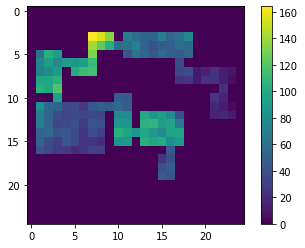

In [447]:
plt.imshow(env.visited.T)
plt.colorbar()

### 2. Create triplets

1. 2000 anchors randomly sampled from collected data
2. Positive samples are defined as +/- 3 time steps from anchor, i.e. [t - 3, t + 3]
3. Negative samples are randomly sampled from [t - 30, t - 15] and [t + 15, t + 30]
4. Made sure that triplets all come from same episode

In [448]:
X = []
n_samples = np_data.shape[0]
num_anchors = 2000
anchors = np.random.choice(range(n_samples), size=num_anchors)
neg_threshold = 15
pos_threshold = 3

In [449]:
for anchor in anchors:
    anchor_episode = episodes[anchor]
    
    pos_choices = []
    for idx in range(max(0, anchor - pos_threshold), anchor):
        if episodes[idx] == anchor_episode:
            pos_choices.append(idx)
            
    for idx in range(anchor + 1, min(n_samples, anchor + pos_threshold + 1)):
        if episodes[idx] == anchor_episode:
            pos_choices.append(idx)
    
    neg_choices = []
    for idx in range(max(0, anchor - (2 * neg_threshold)), anchor - neg_threshold + 1):
        if episodes[idx] == anchor_episode:
            neg_choices.append(idx)
            
    for idx in range(anchor + neg_threshold, min(n_samples, anchor + (2 * neg_threshold) + 1)):
        if episodes[idx] == anchor_episode or True:
            neg_choices.append(idx)
        
    pos_sample = np.random.choice(pos_choices)
    neg_sample = np.random.choice(neg_choices)
    X.append([anchor, pos_sample, neg_sample])

In [450]:
X = np.array(X)

In [451]:
data = torch.Tensor(np_data).to(device)

In [452]:
anchor_data = data[X[:, 0]].detach().cpu().numpy()
pos_data = data[X[:, 1]].detach().cpu().numpy()
neg_data = data[X[:, 2]].detach().cpu().numpy()

In [453]:
def get_coord(data):
    N = data.shape[0]
    h, w = data.shape[1: 3]
    diff = data[:, :, :, 0] - data[:, :, :, 2]
    coord = np.array(np.unravel_index(diff.reshape(N, -1).argmax(axis=1), (h, w))).T
    return coord

In [454]:
anchor_coord = get_coord(anchor_data)
pos_coord = get_coord(pos_data)
neg_coord = get_coord(neg_data)

In [455]:
env_true_dist = env.get_true_distances()

In [456]:
pos_dist = []
neg_dist = []
count = 0

for a, p, n in zip(anchor_coord, pos_coord, neg_coord):
    a_x, a_y = a
    p_x, p_y = p
    n_x, n_y = n
    pos_d = env_true_dist[a_y, a_x, p_y, p_x]
    pos_dist.append(pos_d)

    neg_d = env_true_dist[a_y, a_x, n_y, n_x]
    neg_dist.append(neg_d)

In [457]:
print(np.mean(pos_dist))
print(np.std(pos_dist))

1.1185
0.815755937765702


In [458]:
print(np.mean(neg_dist))
print(np.std(neg_dist))

3.346
3.266693129144518


### 3. Define model

1. 2 conv layers, 1 linear layer
2. Feature size = 64

In [459]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models
from torch.autograd import Function

class BatchNormConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv2d = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batch_norm = nn.BatchNorm2d(out_channels, eps=1e-3)

    def forward(self, x):
        x = self.conv2d(x)
        x = self.batch_norm(x)
        return F.relu(x, inplace=True)

class Dense(nn.Module):
    def __init__(self, in_features, out_features, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation

    def forward(self, x):
        x = self.linear(x)
        if self.activation is not None:
            x = self.activation(x, inplace=True)
        return x

class EmbeddingNet(nn.Module):
    def normalize(self, x):
        buffer = torch.pow(x, 2)
        normp = torch.sum(buffer, 1).add_(1e-10)
        normalization_constant = torch.sqrt(normp)
        output = torch.div(x, normalization_constant.view(-1, 1).expand_as(x))
        return output

class TCN(EmbeddingNet):

    def __init__(
            self,
            image_shape,
            output_size,
            feature_size=64,
            norm_output=True
            ):
        super().__init__()
        h, w, c = image_shape

        self.output_size = output_size
        self.feature_size = feature_size
        self.norm_output = norm_output
        
        self.alpha = 10.0

        conv_embedding_size = 32 * (((h - 3) // 2) - 1) ** 2

        self.encoder = nn.Sequential(
            # 25 x 25 x 3
            nn.Conv2d(c, 32, (3, 3), stride=2),
            nn.ReLU(),
            # 12 x 12 x 3
            nn.Conv2d(32, 32, (3, 3), stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(conv_embedding_size, feature_size),
        )

    def forward(self, obs):
        x = obs.type(torch.float)
        x = x.permute(0, 3, 1, 2)
        x = self.encoder(x)
        if self.norm_output:
            return self.normalize(x) * self.alpha
        else:
            return x
    
class TCNModel(EmbeddingNet):
    def __init__(self, inception):
        super().__init__()
        self.transform_input = True
        self.Conv2d_1a_3x3 = inception.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = inception.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = inception.Conv2d_2b_3x3
        self.Conv2d_3b_1x1 = inception.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = inception.Conv2d_4a_3x3
        self.Mixed_5b = inception.Mixed_5b
        self.Mixed_5c = inception.Mixed_5c
        self.Mixed_5d = inception.Mixed_5d
        self.Conv2d_6a_3x3 = BatchNormConv2d(288, 100, kernel_size=3, stride=1)
        self.Conv2d_6b_3x3 = BatchNormConv2d(100, 20, kernel_size=3, stride=1)
        self.SpatialSoftmax = nn.Softmax2d()
        self.FullyConnected7a = Dense(4 * 4 * 20, 32)

        self.alpha = 10.0

    def forward(self, obs):
        x = obs.type(torch.float)
        x = x.permute(0, 3, 1, 2)
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        # 25 x 25 x 3
        x = self.Conv2d_1a_3x3(x)
        # 12 x 12 x 32 
        x = self.Conv2d_2a_3x3(x)
        # 10 x 10 x 32
        x = self.Conv2d_2b_3x3(x)
        # 10 x 10 x 64
        x = self.Conv2d_3b_1x1(x)
        # 10 x 10 x 80
        x = self.Conv2d_4a_3x3(x)
        # 8 x 8 x 192
        x = self.Mixed_5b(x)
        # 8 x 8 x 256
        x = self.Mixed_5c(x)
        # 8 x 8 x 288
        x = self.Mixed_5d(x)
        # 8 x 8 x 288
        x = self.Conv2d_6a_3x3(x)
        # 6 x 6 x 100
        x = self.Conv2d_6b_3x3(x)
        # 4 x 4 x 20
        x = self.SpatialSoftmax(x)
        # 4 x 4 x 20
        x = self.FullyConnected7a(x.view(x.size()[0], -1))
        # 32
        # Normalize output such that output lives on unit sphere.
        # Multiply by alpha as in https://arxiv.org/pdf/1703.09507.pdf
        return self.normalize(x) * self.alpha


def define_model(pretrained=True):
    return TCNModel(models.inception_v3(pretrained=pretrained))

### 4. Training

1. Defined distance function to be -1 * cosine similarity of features
2. Trained with triplet hinge loss
3. Margin between positive and negative distance should be 2.0

In [475]:
def l2_distance(a, b, norm=False):
    if norm:
        a = a / torch.norm(a, dim=1, keepdim=True)
        b = b / torch.norm(b, dim=1, keepdim=True)
    return torch.norm(a - b, dim=1)

def cos_distance(a, b, norm=False):
    if norm:
        a = a / torch.norm(a, dim=1, keepdim=True)
        b = b / torch.norm(b, dim=1, keepdim=True)
    return -1 * torch.sum(a * b, dim=1)

In [483]:
del model
feature_size = 64
model = TCN(env.observation_space.shape, env.action_space.n, feature_size, True)
# model = define_model()
model.to(device)
N = X.shape[0]

In [484]:
# learning_rate = 1e-2
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# learning_rate_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 500, 1000], gamma=0.1)

In [485]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [486]:
RUN_ID = 3

In [487]:
epochs = 5000
batch_size = 256
clip_grad_norm = 10
log_interval = 500
margin = 2.0

In [488]:
losses = []
avg_d_pos = []
avg_d_neg = []
grad_norms = []

In [489]:
for epoch in range(epochs):
    permutation = torch.randint(0, N, (N, ))
    
    epoch_losses = []
    epoch_d_pos = []
    epoch_d_neg = []
    epoch_grad_norms = []
    
    for i in range(0, N, batch_size):
        optimizer.zero_grad()
        
        indices = permutation[i: i + batch_size]
        
        X_batch = X[indices]
        
        anchor_embeddings = model(data[X_batch[:, 0]])
        pos_embeddings = model(data[X_batch[:, 1]])
        neg_embeddings = model(data[X_batch[:, 2]])
        
#         d_pos = cos_distance(anchor_embeddings, pos_embeddings, True)
#         d_neg = cos_distance(anchor_embeddings, neg_embeddings, True)
        d_pos = l2_distance(anchor_embeddings, pos_embeddings)
        d_neg = l2_distance(anchor_embeddings, neg_embeddings)
        
        epoch_d_pos.append(d_pos.data.cpu().numpy().mean())
        epoch_d_neg.append(d_neg.data.cpu().numpy().mean())
        
        loss = torch.clamp(margin + d_pos - d_neg, min=0.0).mean()
        
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

        optimizer.step()
            
        epoch_losses.append(loss.data.cpu().numpy())
        epoch_grad_norms.append(grad_norm)
    
    # learning_rate_scheduler.step()
    
    losses.append(np.mean(epoch_losses))
    avg_d_pos.append(np.mean(epoch_d_pos))
    avg_d_neg.append(np.mean(epoch_d_neg))
    grad_norms.append(np.mean(epoch_grad_norms))
    
    if epoch % log_interval == 0:
        print('Epoch {}: loss = {:.3f}, d_pos = {:.3f}, d_neg = {:.3f}'.format(epoch,
                                                                               np.mean(losses[-log_interval:]),
                                                                               np.mean(avg_d_pos[-log_interval:]),
                                                                               np.mean(avg_d_neg[-log_interval:])))
        
        torch.save(model.state_dict(), 'models/TCN-{}-{}.pt'.format(RUN_ID, epoch))

Epoch 0: loss = 1.841, d_pos = 0.311, d_neg = 0.470
Epoch 500: loss = 0.573, d_pos = 2.862, d_neg = 6.341
Epoch 1000: loss = 0.478, d_pos = 3.744, d_neg = 8.083
Epoch 1500: loss = 0.332, d_pos = 4.801, d_neg = 9.947
Epoch 2000: loss = 0.250, d_pos = 5.497, d_neg = 10.912
Epoch 2500: loss = 0.213, d_pos = 5.797, d_neg = 11.256
Epoch 3000: loss = 0.196, d_pos = 5.958, d_neg = 11.439
Epoch 3500: loss = 0.184, d_pos = 6.061, d_neg = 11.543
Epoch 4000: loss = 0.178, d_pos = 6.123, d_neg = 11.618
Epoch 4500: loss = 0.170, d_pos = 6.168, d_neg = 11.682


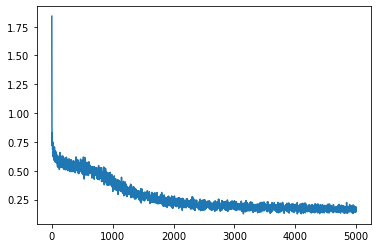

In [490]:
plt.plot(losses)

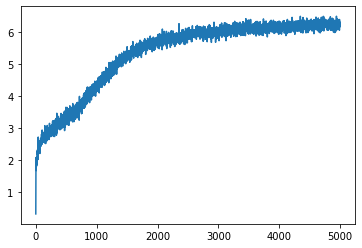

In [491]:
plt.plot(avg_d_pos)

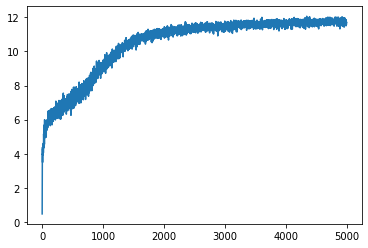

In [492]:
plt.plot(avg_d_neg)

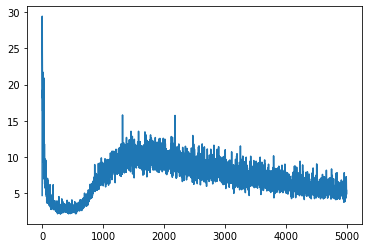

In [493]:
plt.plot(grad_norms)

### 5. Visualize results

1. Computed features for all positive states
2. Computed cosine similarity between all states and a selected subgoal state, e.g. (4, 13)

In [241]:
# obs = env.reset()
# h, w = env.grid.height, env.grid.width
# features = torch.zeros((h, w, 4, 32), dtype=torch.float)
# features += np.nan

# positions = set()
# for r in range(19):
#     for c in range(19):
#         if r not in [0, 9, 18] and c not in [0, 9, 18]:
#             for action in range(4):
#                 env.env.env.unwrapped.agent_pos = np.array([r, c])
#                 _, _, done, _ = env.step(action)

#                 pos = tuple(env.agent_pos)
#                 if pos not in positions:
#                     positions.add(pos)

#                 if done:
#                     env.reset()

# for pos in positions:
#     for direction in range(4):
#         env.env.env.unwrapped.agent_pos = np.array(pos)
#         env.env.env.unwrapped.agent_dir = direction
#         obs, _, _, _ = env.step(4)
#         model_inputs = torch.Tensor(obs).unsqueeze(0).to(device)
#         features[pos[0], pos[1], direction] = model(model_inputs)

In [494]:
load_run_id = 3
load_epoch = 2000

In [495]:
params = torch.load('models/TCN-{}-{}.pt'.format(load_run_id, load_epoch), map_location=device)

In [496]:
model.load_state_dict(params)

<All keys matched successfully>

In [497]:
h, w = env.grid.height, env.grid.width
features = torch.zeros((h, w, 4, feature_size), dtype=torch.float)
features += np.nan

for pos in env.get_possible_pos():
    x, y = pos
    for direction in range(4):
        env.unwrapped.agent_pos = np.array([x, y])
        env.unwrapped.agent_dir = direction
        obs, _, _, _ = env.get_current_state()

        model_inputs = torch.Tensor(obs).unsqueeze(0).to(device)

        features[x, y, direction] = model(model_inputs)

In [498]:
subgoal = (3, 5)

np_features = features.detach().numpy()
features_matrix = np_features.mean(axis=2)
features_matrix = features_matrix / np.linalg.norm(features_matrix, ord=2, axis=2, keepdims=True)

subgoal_features = features_matrix[subgoal]

side_size = features_matrix.shape[0]
heatmap = np.zeros((side_size, side_size))
for r in range(side_size):
    for c in range(side_size):
        heatmap[r, c] = np.dot(features_matrix[r, c], subgoal_features)
#         heatmap[r, c] = np.linalg.norm(features_matrix[r, c] - subgoal_features)

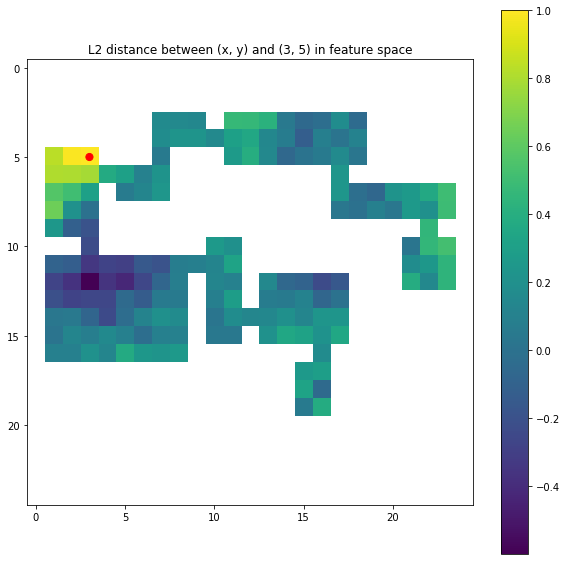

In [499]:
plt.figure(figsize=(10, 10))
plt.imshow(heatmap.T)
circle = plt.Circle(subgoal, 0.2, color='r')
plt.gca().add_artist(circle)
plt.title('L2 distance between (x, y) and {} in feature space'.format(subgoal))
plt.colorbar()

#### T-SNE

In [500]:
np_features = features.detach().numpy()
raw_features = np_features.mean(axis=2)

In [501]:
np.nanmean(raw_features)

-0.003034275

In [502]:
valid_features = raw_features.reshape(25 * 25, feature_size)
walls = np.isnan(valid_features).any(axis=1)
valid_features = valid_features[~walls]

In [503]:
embeddings = TSNE(n_components=2).fit_transform(valid_features)

In [504]:
rooms = np.zeros((25, 25))
for i, room in enumerate(env.rooms, 1):
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            rooms[x, y] = i
rooms = rooms.reshape(25 * 25)[~walls]

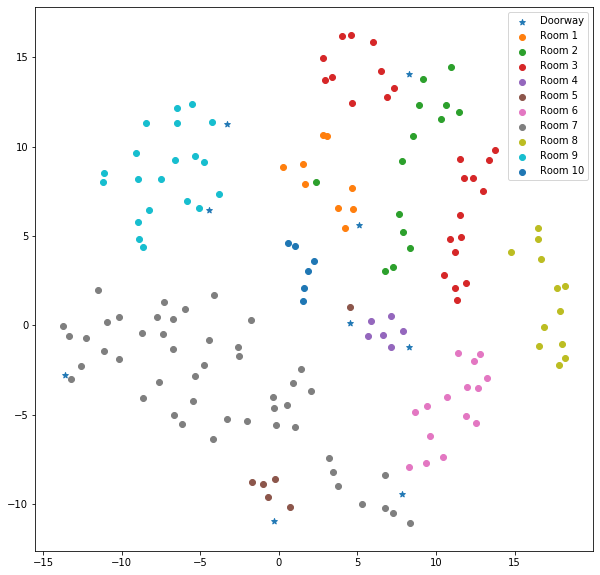

In [505]:
figure = plt.figure(figsize=(10, 10))
tsne_data = embeddings[rooms == 0]
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], label='Doorway', marker='*')
for i in range(1, len(env.rooms) + 1):
    tsne_data = embeddings[rooms == i]
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], label='Room ' + str(i))
plt.legend()